In [1]:
import FI_estimation
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy import ndimage

torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

/home/maximilian/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# lognormal; all moments exist but the MGF(t) does not exist for positive t
type = np.float64
def reshape(speckles):
    reshaped = np.zeros(shape = (speckles.shape[0]*speckles.shape[1], speckles.shape[2]))
    for pos in range(speckles.shape[0]):
        for i in range(speckles.shape[1]):
            reshaped[i+pos*speckles.shape[1]] = speckles[pos, i, :]
    return reshaped

data = np.load('Data'+os.sep+'ES_log_normal_train_X.npy') 
positions = np.load('Data'+os.sep+'ES_log_normal_train_Y.npy')

x_tr = reshape(data)
y_tr = reshape(positions)[:,0]
x_tst = np.load("Data"+os.sep+"log_normal_test_X.npy")
delta = 0.1

def shuffle_split_data(X, y, ratio=0.5):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, ratio*100)

    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, X_test, y_train, y_test
X_train, X_val, Y_train, Y_val = shuffle_split_data(x_tr, y_tr, ratio=0.8)
#
X_train = X_train.astype(type)
Y_train = Y_train.astype(type)
X_val = X_val.astype(type)
Y_val = Y_val.astype(type)
#
torch.set_default_tensor_type(torch.DoubleTensor)
train_set = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train).T)
val_set = TensorDataset(torch.tensor(X_val), torch.tensor(Y_val).T)

bs = 128
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
validation_loader = Data.DataLoader(val_set, batch_size=bs, shuffle=True)

/tmp/ipykernel_14554/337537569.py:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755832681/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  train_set = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train).T)


In [3]:
x_tst = x_tst.astype(np.float64)

In [4]:
class Model(nn.Module):
    def __init__(self, n):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(n[0], n[1])
        self.linear2 = nn.Linear(n[1], n[2])
        self.linear3 = nn.Linear(n[2], n[3])
        self.linear4 = nn.Linear(n[3], n[4])
        self.linear5 = nn.Linear(n[4], n[5])
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)    
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)       
        x = F.relu(x)
        x = self.linear5(x)  
        return x
n = [10,150,100,50,25,1]

In [5]:
Nruns = 10
starting_epoch = 0
criterion =  nn.MSELoss()
n_epochs = 20
lr = 1e-4
training_loss = 0.
validation_loss = 0.
net = Model(n).to(device)
all_losses = []
all_losses_val = []
all_losses.append(training_loss/len(train_loader))
all_losses_val.append(validation_loss/len(validation_loader))
torch.save(net,  'Models' +os.sep+ 'epoch' + str(0)+'Lognormal.pth')
for epoch in range(starting_epoch, starting_epoch + n_epochs):
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.00)
    net.train()
    training_loss = 0.
    validation_loss = 0.
    batch_count = 0
    for inputs, target in train_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        batch_count += 1
        y_pred = net(inputs)
        loss = criterion(y_pred,  torch.unsqueeze(target,dim=1)  )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    net.eval()
    with torch.no_grad():
        for inputs, target in validation_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            y_pred = net(inputs)
            loss_val = criterion(y_pred,  torch.unsqueeze(target,dim=1) )
            validation_loss += loss_val.item()
    print("epoch= ", epoch, ", val= ", validation_loss/len(validation_loader),", train = ", training_loss/len(train_loader))
    torch.save(net,   'Models' +os.sep+ 'epoch' + str(epoch+1)+'Lognormal.pth')
    all_losses_val.append(validation_loss/len(validation_loader))
    all_losses.append(training_loss/len(train_loader))

epoch=  0 , val=  0.24120495663961222 , train =  1.1449761391749576
epoch=  1 , val=  0.16666692548943537 , train =  0.1997811480839942
epoch=  2 , val=  0.14869151219137747 , train =  0.16570663569291091
epoch=  3 , val=  0.1426857049323928 , train =  0.15027553029978544
epoch=  4 , val=  0.13187432845583452 , train =  0.14113781304980386
epoch=  5 , val=  0.12566895862051336 , train =  0.13483959065831827
epoch=  6 , val=  0.1221618915852298 , train =  0.12925901297103304
epoch=  7 , val=  0.11876819782446868 , train =  0.12564931873278987
epoch=  8 , val=  0.11974259105700957 , train =  0.12271040670896095
epoch=  9 , val=  0.1175954731812061 , train =  0.12101518463435161
epoch=  10 , val=  0.11085902056216805 , train =  0.11895673674412925
epoch=  11 , val=  0.11660588890626834 , train =  0.11688904456397928
epoch=  12 , val=  0.12313872866673121 , train =  0.11604211461401635
epoch=  13 , val=  0.10861886009501952 , train =  0.11518415867451658
epoch=  14 , val=  0.11173247745273

In [4]:
# x_tst = x_tst.astype(np.float64)
# x_minus = x_tst[0]
# x_middle = x_tst[1]
# x_plus = x_tst[2]

In [5]:
### calculating the FI Flow for different runs:
### parameters 
fi_in = 10
kappa = 0.1 # ratio of slopes
gamma = 0.05 # stop when the LFI doesn't improve in the first iterations 
noise = 0.01 # noise added
step = 50 # 10 increase of dimensionality
upperLimit = 1000 # maximum increase 
n_epochs = 20
X = x_tst
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2]) 
X = torch.tensor(X)
print("X.shape", X.shape)
fi_array = []
for epoch in range(n_epochs):
    print("epoch: ", epoch)
    net = Model(n)
    net = torch.load('Models'+os.sep + 'epoch'+ str(epoch)+'Lognormal.pth', map_location=torch.device('cpu'))
    net.eval()
    ###
    return_nodes = {
        "linear1": "linear1",
        "linear2": "linear2",
        "linear3": "linear3",
        "linear4": "linear4"}
    model2 = create_feature_extractor(net, return_nodes=return_nodes)
    intermediate_outputs = model2(X)

    linear1 = intermediate_outputs['linear1']
    linear2 = intermediate_outputs['linear2']
    linear3 = intermediate_outputs['linear3']
    linear4 = intermediate_outputs['linear4']
    layer_out = net(X)
    ##############
    linear1 = linear1.reshape(3 , linear1.shape[0]//3, linear1.shape[1])
    linear2 = linear2.reshape(3 , linear2.shape[0]//3, linear2.shape[1])
    linear3 = linear3.reshape(3 , linear3.shape[0]//3, linear3.shape[1])
    linear4 = linear4.reshape(3 , linear4.shape[0]//3, linear4.shape[1])
    layer_out = layer_out.reshape(3 , layer_out.shape[0]//3, layer_out.shape[1])
    ### converst to numpy arrays
    linear1 = linear1.detach().numpy()
    linear2 = linear2.detach().numpy()
    linear3 = linear3.detach().numpy()
    linear4 = linear4.detach().numpy()
    layer_out = layer_out.detach().numpy()
    ### it might not converge without noise!
    fi_1_temp = FI_estimation.get_LFI(linear1, delta, 1e-9)
    fi_2_temp = FI_estimation.get_LFI(linear2, delta, 1e-9)
    fi_3_temp = FI_estimation.get_LFI(linear3, delta, 1e-9)
    fi_4_temp = FI_estimation.get_LFI(linear4, delta, 1e-9)
    fi_out_temp = FI_estimation.get_LFI(layer_out, delta, 1e-9)

    linear1 = (FI_estimation.ReLU(linear1))
    linear2 = (FI_estimation.ReLU(linear2))
    linear3 = (FI_estimation.ReLU(linear3))
    linear4 = (FI_estimation.ReLU(linear4))
    layer_out = (layer_out)

    fi_1 = FI_estimation.get_FI(linear1, delta, upperLimit, step, kappa, constant_threshold=gamma, 
                               noise_factor=noise, biasedLFI=True)
    fi_2 = FI_estimation.get_FI(linear2, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_3 = FI_estimation.get_FI(linear3, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_4 = FI_estimation.get_FI(linear4, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)
    fi_out = FI_estimation.get_FI(layer_out, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)

#     fi_1 = max(fi_1_temp, fi_1)
#     fi_2 = max(fi_2_temp, fi_2)
#     fi_3 = max(fi_3_temp, fi_3)
#     fi_4 = max(fi_4_temp, fi_4)
#     fi_out = max(fi_out_temp[0], fi_out)
    if isinstance(fi_out, np.ndarray): fi_out = fi_out.item()
    fi = np.array([fi_in,fi_1,fi_2,fi_3,fi_4,fi_out])
    print(fi)
    fi_array.append(fi)
    print("#------------------------------------------------------#")

X.shape torch.Size([450000, 10])
epoch:  0
components ignored:  140
calculating FI
components ignored:  11
up:  0


KeyboardInterrupt: 

In [1]:
plt.plot(np.array(fi_array).T)
plt.show()

NameError: name 'plt' is not defined

In [15]:
#np.save("Plots" + os.sep + "fi_flow_Lognormal.npy", np.array(fi_array))

### trash

In [6]:
def get_LFI(data, delta, cutoff):
    mu = np.mean(data, axis=1)
    dmu = (mu[2]-mu[0])/(2*delta)
    cov = (np.cov(data[0].T)+np.cov(data[2].T))/2
    if data.shape[2] > 1:
        u, s, vh = np.linalg.svd(cov, full_matrices=True)
        count = 0
        s_inv = np.zeros(shape=s.shape[0])
        for i in range(s.shape[0]):
            if np.abs(s[i])<cutoff:
                count += 1
                s[i] = 0.
            else:
                s_inv[i] = 1/s[i]
        if count > 0:
            print("components ignored: ", count)
        lfi = dmu.T@vh.T@np.diag(s_inv)@u.T@dmu  
    elif data.shape[2] == 1:
        lfi = dmu**2/cov
    else:
        print("wrong shape of data")
    T = data.shape[1]
    N = data.shape[2]
    return lfi - 2*N/(T*(2*delta)**2)
get_LFI(linear2, delta, 1e-9)

components ignored:  16


9.051985755632222

In [9]:
upperLimit = 1500
step = 100

In [7]:
curve = FI_estimation.get_FI_curve(linear4, delta, upperLimit, step, kappa, constant_threshold=gamma, 
                               noise_factor=noise, biasedLFI=True)

lfi =  5.654014351960666
lfi =  6.322448077172988
lfi =  6.537939493067665


KeyboardInterrupt: 

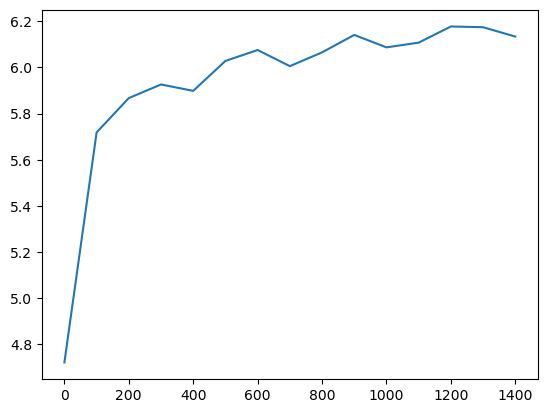

In [12]:
x = []
for up in range(0,upperLimit,step):
    x.append(up)
x = np.array(x)
curve = np.array(curve)
plt.plot(x,curve)

In [39]:

np.savez('Plots'+os.sep+'FIConvergenceLognormal.npz',
         curve=curve,
        x=x)

NameError: name 'x' is not defined

In [12]:
fi_1 = FI_estimation.get_FI(linear2, delta, upperLimit, step, kappa, constant_threshold=gamma, 
                           noise_factor=noise, biasedLFI=True)
fi_1

calculating FI
components ignored:  16
up:  0
up:  50
up:  100
LFI didn't increase after the 3rd iteration:  200


9.14427130645186

In [ ]:
fi_1_temp = FI_estimation.get_LFI(linear1, delta, 1e-9)
fi_2_temp = FI_estimation.get_LFI(linear2, delta, 1e-9)
fi_3_temp = FI_estimation.get_LFI(linear3, delta, 1e-9)
fi_4_temp = FI_estimation.get_LFI(linear4, delta, 1e-9)
fi_out_temp = FI_estimation.get_LFI(layer_out, delta, 1e-9)

In [ ]:
curve = FI_estimation.get_FI_curve(linear1, delta, upperLimit, step, kappa, constant_threshold=gamma, noise_factor=noise, biasedLFI=True)


components ignored:  11
lfi =  9.798664894927976
